In [2]:
!pip install textstat

     |████████████████████████████████| 102kB 6.7MB/s 
     |████████████████████████████████| 1.9MB 45.6MB/s 


In [3]:
#Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import re
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')


from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import textstat
from textblob import TextBlob 
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **1.Data**

In [5]:
train=pd.read_csv("/datalab/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("/datalab/Corona_NLP_test.csv",encoding='latin1')



df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))
print("\n")
print(train.head())
print("\n")
print(train.info())

Training Set Shape = (20419, 6)
Training Set Memory Usage = 0.93 MB
Test Set Shape = (3798, 6)
Test Set Memory Usage = 0.17 MB


   UserName  ScreenName   Location     TweetAt                                      OriginalTweet           Sentiment
0      3799       48751     London  16-03-2020  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1      3800       48752         UK  16-03-2020  advice Talk to your neighbours family to excha...            Positive
2      3801       48753  Vagabonds  16-03-2020  Coronavirus Australia: Woolworths to give elde...            Positive
3      3802       48754        NaN  16-03-2020  My food stock is not the only one which is emp...            Positive
4      3803       48755        NaN  16-03-2020  Me, ready to go at supermarket during the #COV...  Extremely Negative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20419 entries, 0 to 20418
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  -----

In [7]:
# Drop duplicates
train.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (24217, 6)


In [8]:
#Null values

null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)

Null Values in each column:
      column name  Total missing  Percent missing
0       Location           5242          0.21646
1      Sentiment              0          0.00000
2  OriginalTweet              0          0.00000
3        TweetAt              0          0.00000
4     ScreenName              0          0.00000
5       UserName              0          0.00000


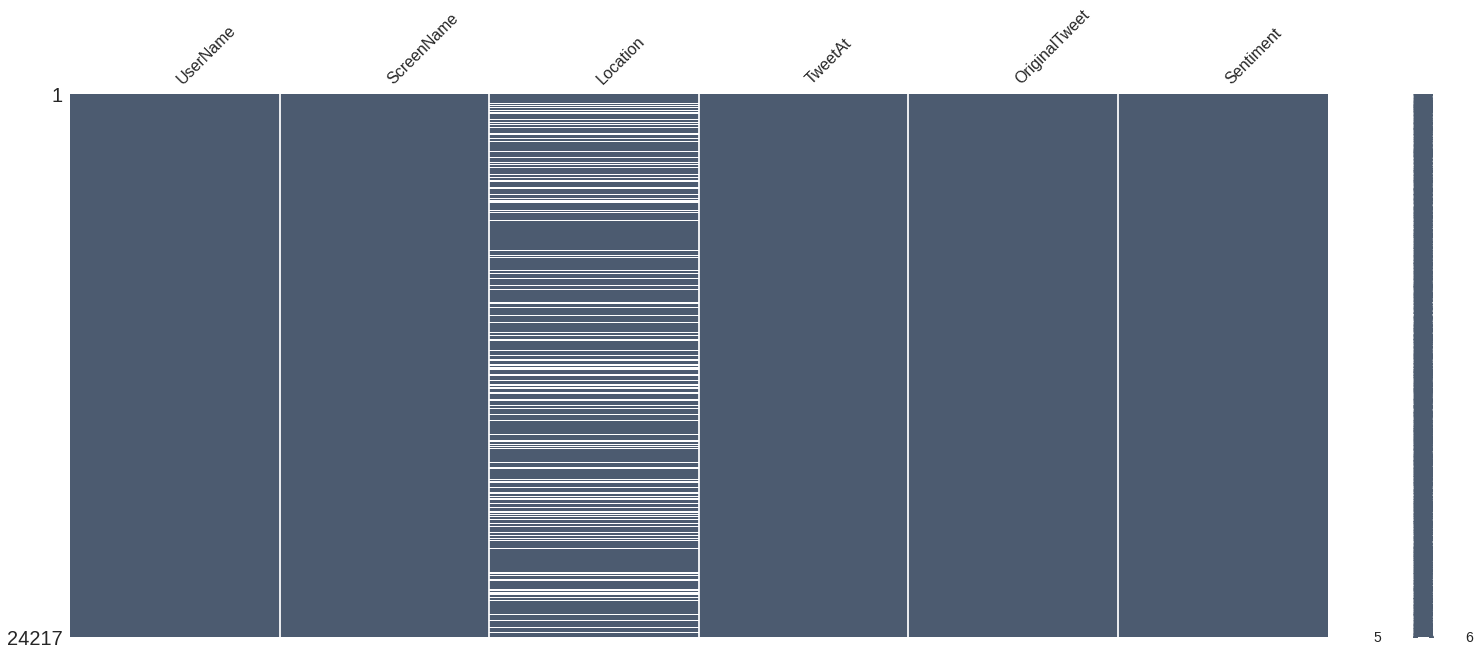

In [9]:
#Missing data as white lines 
import missingno as msno
msno.matrix(df,color=(0.3,0.36,0.44))

In [10]:
print('Total tweets in this data: {}'.format(df.shape[0]))
print('Total Unique Users in this data: {}'.format(df['UserName'].nunique()))

Total tweets in this data: 24217
Total Unique Users in this data: 24217


In [11]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive'
 'nan']
Positive              6493
Negative              6123
Neutral               4266
Extremely Positive    3709
Extremely Negative    3625
nan                      1
Name: Sentiment, dtype: int64


In [12]:
# We will copy the text in another column so that the original text is also there for comparison

df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts(normalize= True)

positive    0.421274
negative    0.402527
neutral     0.176199
Name: sentiment, dtype: float64

# **2.Class Distribution**

In [13]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='winter')

,sentiment,text
2,positive,10202
0,negative,9748
1,neutral,4267


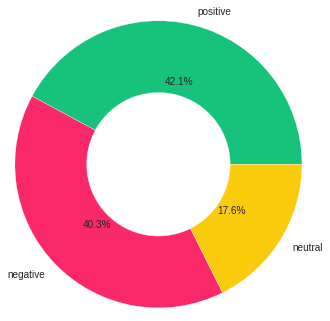

In [14]:
percent_class=class_df.text
labels= class_df.sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

In [39]:
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)

# 3. Number of characters

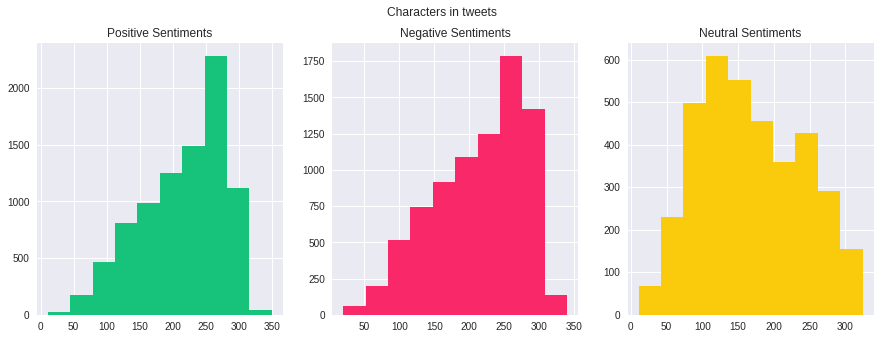

In [17]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

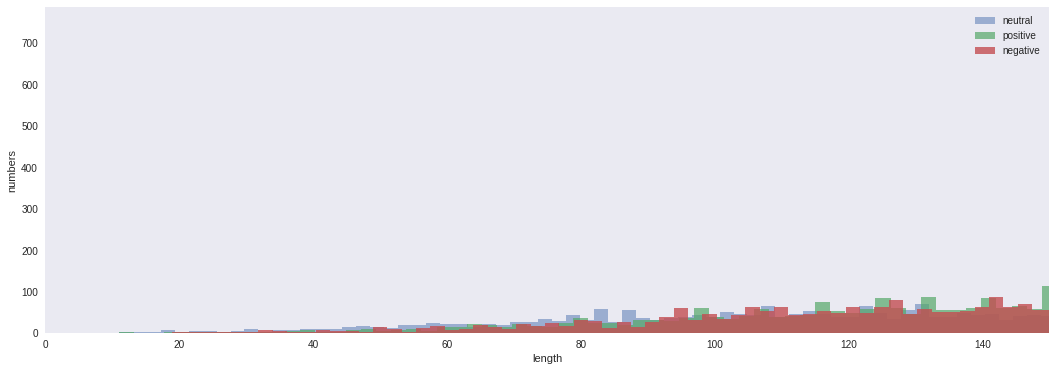

In [18]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
df['length'] = df['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df[df['sentiment'] == "neutral"]['length'], alpha = 0.5, bins=bins, label='neutral')
plt.hist(df[df['sentiment'] == "positive"]['length'], alpha = 0.7, bins=bins, label='positive')
plt.hist(df[df['sentiment'] == "negative"]['length'], alpha = 0.8, bins=bins, label='negative')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

# 4. Number of words in a tweet

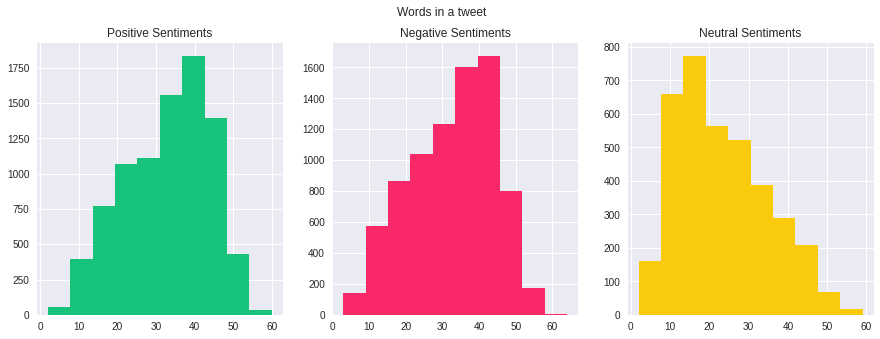

In [19]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

# 5. Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

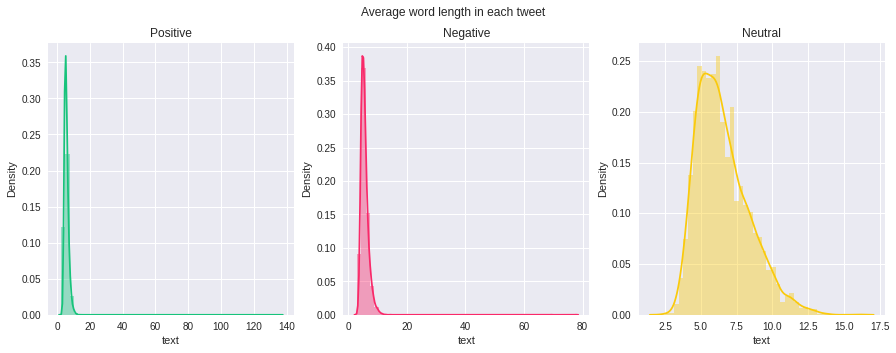

In [20]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))

word=train[train['sentiment']=="positive"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('Positive')


word=train[train['sentiment']=="negative"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('Negative')

word=train[train['sentiment']=="neutral"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#FACA0C')
ax3.set_title('Neutral')


fig.suptitle('Average word length in each tweet')

# 6. Common Stopwords in the tweets

In [22]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['sentiment']==target ]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [23]:
np.array(stop)

array({'do', 'further', 'mustn', 'before', 'against', 'o', 'which', 'her', "shan't", 'their', "you'll", "should've", 'who', 'with', 'in', 'not', 'does', 'own', 'don', 'hadn', 'she', 'being', 'all', 'wouldn', 'to', 'each', "you're", "wouldn't", 'him', 'into', 'couldn', "wasn't", 'has', "hasn't", 'had', 'from', "haven't", 'why', "don't", "won't", 'his', 'they', 'if', "couldn't", "she's", 'y', 'than', 'after', 't', 'but', 'where', 'of', 'those', 'that', 'yourself', 'as', 'isn', 'for', 'such', 'nor', 'haven', 'while', 'again', 'few', "needn't", 'have', 'myself', 'what', 'on', 'it', "hadn't", "mustn't", 'when', 'some', 'yours', 'once', 'should', 'won', 'by', 'll', "didn't", 'then', 'most', 'we', 're', 'himself', 'between', 'was', 'other', 'shouldn', 'ourselves', 'mightn', 'up', 'shan', "weren't", 'i', 'through', 'theirs', 'out', "you've", 'too', 'under', 'themselves', 'because', 'below', 'over', 'more', 'are', 'whom', 'ain', 'be', 'both', 'yourselves', "aren't", 'ours', 'only', 'at', 'off',

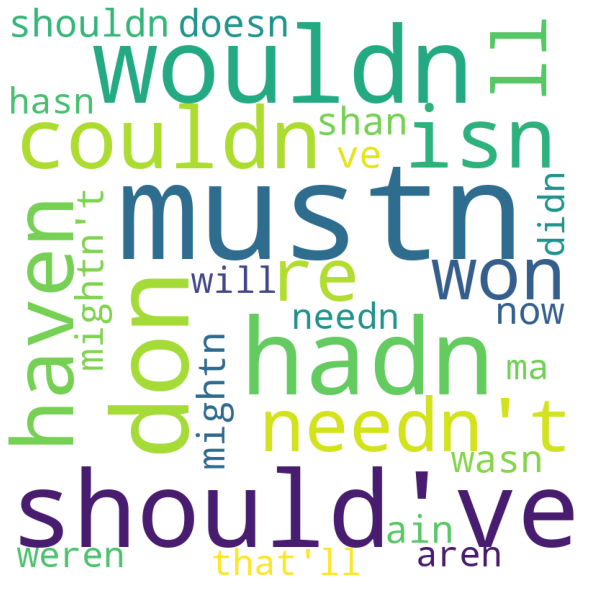

In [24]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  

for val in stop: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<BarContainer object of 10 artists>

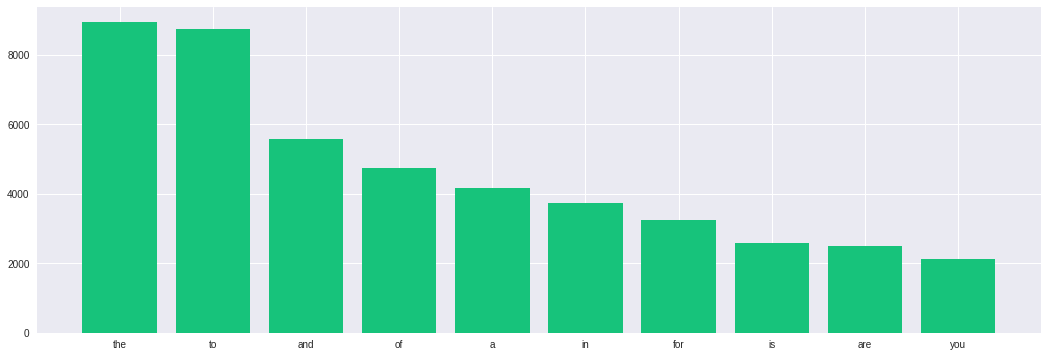

In [25]:
corpus=create_corpus("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

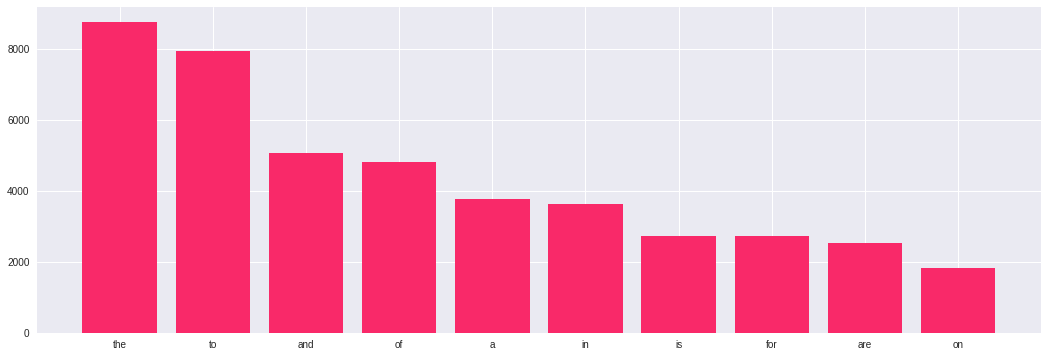

In [26]:
corpus=create_corpus("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

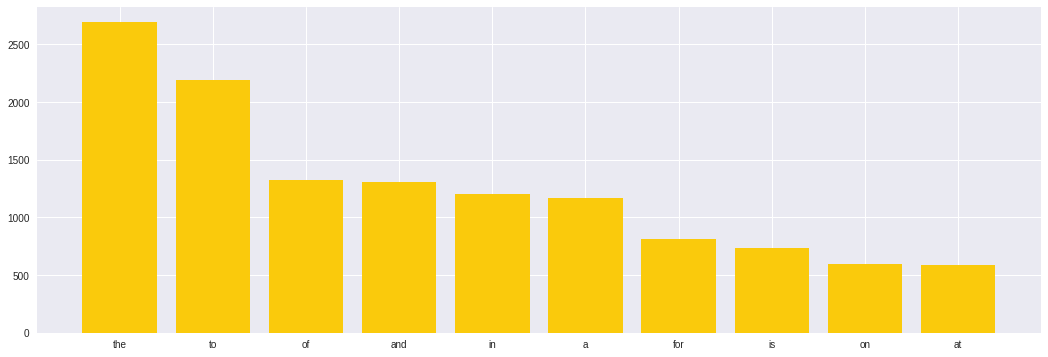

In [27]:
corpus=create_corpus("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

# 7. Punctuations

<BarContainer object of 25 artists>

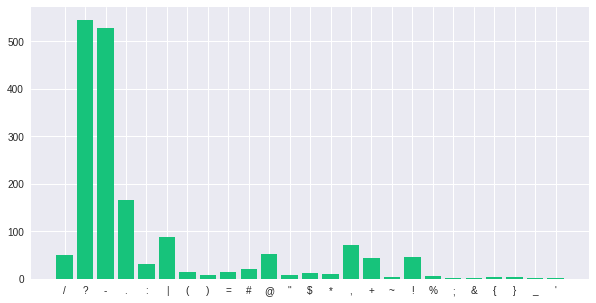

In [28]:
plt.figure(figsize=(10,5))
corpus=create_corpus("positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#17C37B')

<BarContainer object of 24 artists>

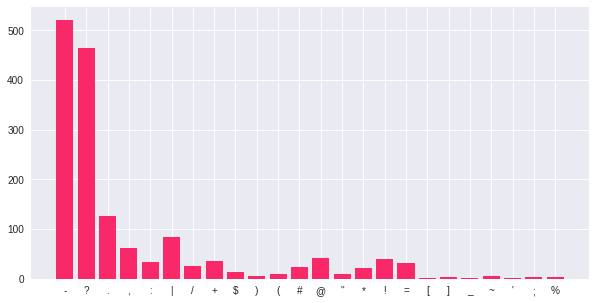

In [29]:
plt.figure(figsize=(10,5))
corpus=create_corpus("negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#F92969')

<BarContainer object of 19 artists>

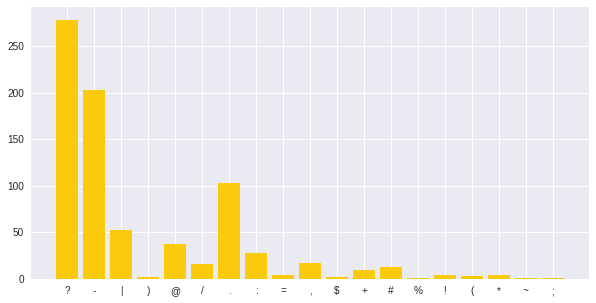

In [30]:
plt.figure(figsize=(10,5))
corpus=create_corpus("neutral")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

        
x,y=zip(*dic.items())
plt.bar(x,y,color='#FACA0C')

# 8. Common Words

In [32]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

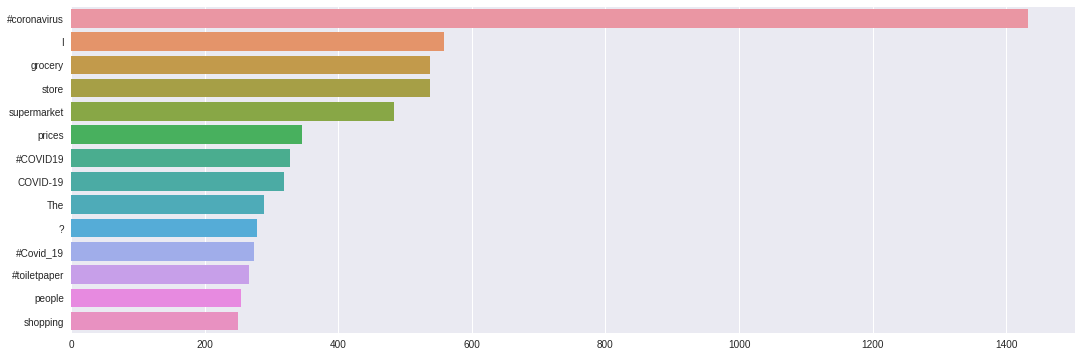

In [33]:
sns.barplot(x=y,y=x)

# 9. Hashtags

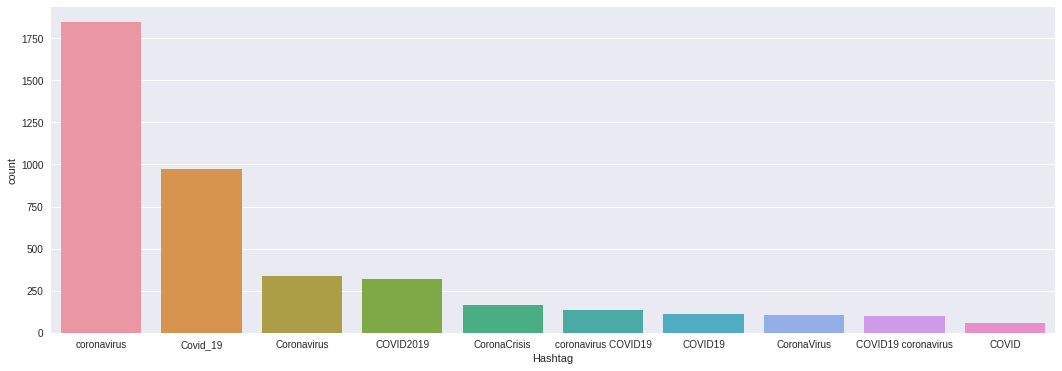

In [34]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hash']=df['text'].apply(lambda x:find_hash(x))
temp=df['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp)

# 10. Mentions

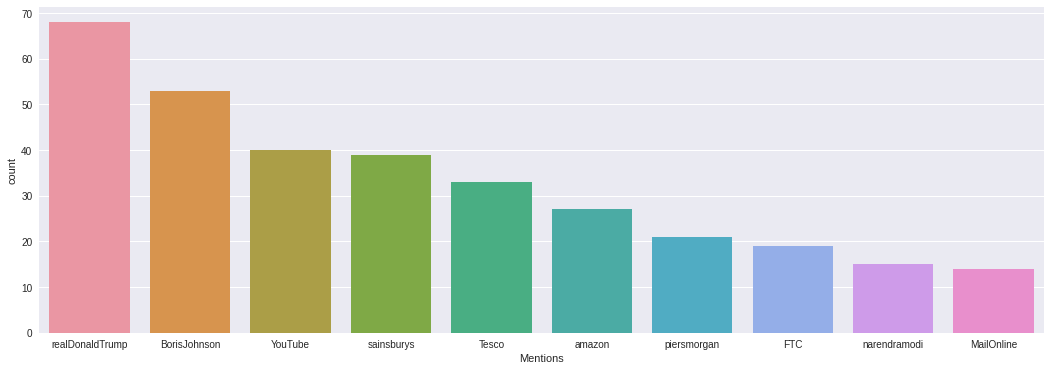

In [35]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

sns.barplot(x="Mentions",y="count", data = temp)